In [43]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random
random.seed(1234)

plt.style.use('ggplot')

dat = pd.read_csv('creditcard1.csv')

print(dat.head())
print('\nThe distribution of the target variable:\n')
dat['Class'].value_counts()


   Time        V1        V2        V3        V4        V5        V6        V7  \
0     0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1     0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2     1 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3     1 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4     2 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

0    1975
1      24
Name: Class, dtype: int64


Means of variables in the two Class categories:


P-values of Welch’s t-tests and shape statistics:

Variable: Time   p-value:  0.000  skewness: -0.000  kurtosis: -1.238
Variable: V1     p-value:  0.815  skewness: -0.887  kurtosis:  2.303
Variable: V2     p-value:  0.112  skewness: -1.699  kurtosis: 13.842
Variable: V3     p-value:  0.019  skewness: -1.510  kurtosis: 15.633
Variable: V4     p-value:  0.005  skewness: -0.053  kurtosis:  0.467
Variable: V5     p-value:  0.026  skewness: -7.849  kurtosis: 205.175
Variable: V6     p-value:  0.371  skewness:  3.666  kurtosis: 41.702
Variable: V7     p-value:  0.501  skewness: 14.029  kurtosis: 410.664
Variable: V8     p-value:  0.823  skewness: -4.554  kurtosis: 36.442
Variable: V9     p-value:  0.006  skewness:  0.895  kurtosis:  5.197
Variable: V10    p-value:  0.027  skewness:  3.409  kurtosis: 28.247
Variable: V11    p-value:  0.412  skewness:  0.119  kurtosis: -0.643
Variable: V12    p-value:  0.514  skewness: -0.280  kurtosis:  0.335

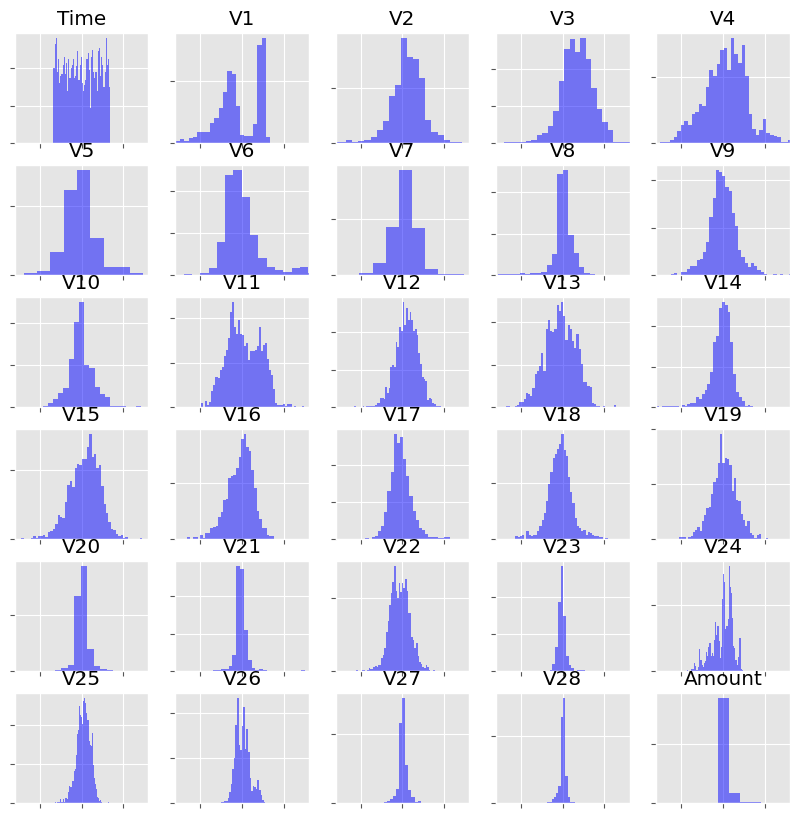

In [44]:

from scipy import stats
from sklearn import preprocessing

dat['Time'] = preprocessing.scale(dat['Time'])
dat['Amount'] = preprocessing.scale(dat['Amount'])

print('\nMeans of variables in the two Class categories:\n')
#pt = pd.pivot_table(dat, values=dat.columns, columns = 'Class', aggfunc='mean')
#print(pt.loc[dat.columns])

print('\nP-values of Welch’s t-tests and shape statistics:\n')
for i in range(30):
    col_name = dat.columns[i]
    t, p_val = stats.ttest_ind(dat.loc[ dat['Class']==0, col_name], dat.loc[ dat['Class']==1, col_name],equal_var=False)  
    skewness = dat.loc[:,col_name].skew()
    kurtosis = stats.kurtosis(dat.loc[:,col_name])
    print('Variable: {:7s}'.format(col_name),end='')    
    print('p-value: {:6.3f}  skewness: {:6.3f}  kurtosis: {:6.3f}'.format(p_val, skewness, kurtosis))

    
fig, axes = plt.subplots(nrows=6, ncols=5,figsize=(10,10))
axes = axes.flatten()

columns = dat.columns
for i in range(30):
  axes[i].hist(dat[columns[i]], bins=50,facecolor='b',alpha=0.5)
  axes[i].set_title(columns[i])
  axes[i].set_xlim([-4., +4.])
  plt.setp(axes[i].get_xticklabels(), visible=False) 
  plt.setp(axes[i].get_yticklabels(), visible=False) 



In [45]:


Class = dat['Class'].values

allIndices = np.arange(len(Class))
np.random.shuffle(allIndices) ## shuffle the indices of the observations

numTrain = int(round(0.40*len(Class)))
numValid = int(round(0.30*len(Class)))
numTest = len(Class)-numTrain-numValid

inTrain = allIndices[:numTrain]
inValid = allIndices[numTrain:(numTrain+numValid)]
inTest =  allIndices[(numTrain+numValid):]

train = dat.iloc[inTrain,:30]
valid= dat.iloc[inValid,:30]
test =  dat.iloc[inTest,:30]

trainY = Class[inTrain]
validY = Class[inValid]
testY = Class[inTest]

In [46]:
import xgboost as xgb

dtrain = xgb.DMatrix(train, label=trainY)
dvalid = xgb.DMatrix(valid, label=validY)
dtest = xgb.DMatrix(test, label=testY)

## fixed parameters
num_rounds=20 # number of boosting iterations

param = {'silent':1,
         'min_child_weight':1,
         'objective':'binary:logistic',
         'eval_metric':'auc',
         'seed' : 1234}  

In [47]:

from collections import OrderedDict

ratio_neg_to_pos = sum(trainY==0)/sum(trainY==1)  ## = 608
print('Ratio of negative to positive instances: {:6.1f}'.format(ratio_neg_to_pos))

## parameters to be tuned
tune_dic = OrderedDict()

tune_dic['max_depth']= [5,10,15,20,25] ## maximum tree depth
tune_dic['subsample']=[0.5,0.6,0.7,0.8,0.9,1.0] ## proportion of training instances used in trees
tune_dic['colsample_bytree']= [0.5,0.6,0.7,0.8,0.9,1.0] ## subsample ratio of columns
tune_dic['eta']= [0.01,0.05,0.10,0.20,0.30,0.40]  ## learning rate
tune_dic['gamma']= [0.00,0.05,0.10,0.15,0.20]  ## minimum loss function reduction required for a split
tune_dic['scale_pos_weight']=[30,40,50,300,400,500,600,700] ## relative weight of positive/negative instances

lengths = [len(lst) for lst in tune_dic.values()]

combs=1
for i in range(len(lengths)):
    combs *= lengths[i]
print('Total number of combinations: {:16d}'.format(combs))  

maxiter=100

columns=[*tune_dic.keys()]+['F-Score','Best F-Score']
results = pd.DataFrame(index=range(maxiter), columns=columns) ## dataframe to hold training results


Ratio of negative to positive instances:   79.0
Total number of combinations:            43200


In [48]:
def perf_measures(preds, labels, print_conf_matrix=False):
    
    act_pos=sum(labels==1) ## actual positive
    act_neg=len(labels) - act_pos ## actual negative
    
    pred_pos=sum(1 for i in range(len(preds)) if (preds[i]>=0.5)) ## predicted positive
    true_pos=sum(1 for i in range(len(preds)) if (preds[i]>=0.5) & (labels[i]==1)) ## predicted negative
    
    false_pos=pred_pos - true_pos ## false positive
    false_neg=act_pos-true_pos ## false negative
    true_neg=act_neg-false_pos ## true negative
      
    precision = true_pos/pred_pos ## tp/(tp+fp) percentage of correctly classified predicted positives
    recall = true_pos/act_pos ## tp/(tp+fn) percentage of positives correctly classified
    
    f_score = 2*precision*recall/(precision+recall) 
    
    if print_conf_matrix:
        print('\nconfusion matrix')
        print('----------------')
        print( 'tn:{:6d} fp:{:6d}'.format(true_neg,false_pos))
        print( 'fn:{:6d} tp:{:6d}'.format(false_neg,true_pos))
    
    return(f_score)


def do_train(cur_choice, param, train,train_s,trainY,valid,valid_s,validY,print_conf_matrix=False):
    ## train with given fixed and variable parameters
    ## and report the F-score on the validation dataset
    
    print('Parameters:')
    for (key,value) in cur_choice.items():
        print(key,': ',value,' ',end='')
        param[key]=value
    print('\n')    
    
##    the commented-out segment below uses a watchlist to monitor the progress of the boosting iterations 
##    evallist  = [(train,train_s), (valid,valid_s)]
##    model = xgb.train( param, train, num_boost_round=num_rounds,
##                      evals=evallist,verbose_eval=False)  
    
    model = xgb.train( param, train, num_boost_round=num_rounds)  
    
    preds = model.predict(valid)
    labels = valid.get_label()
      
    f_score = perf_measures(preds, labels,print_conf_matrix)
    
    return(f_score, model)    


In [49]:


def next_choice(cur_params=None):
    ## returns a random combination of the variable parameters (if cur_params=None)
    ## or a random neighboring combination from cur_params
    if cur_params:
        ## chose parameter to change
        ## parameter name and current value
        choose_param_name, cur_value = random.choice(list(cur_choice.items())) ## parameter name 
       
        all_values =  list(tune_dic[choose_param_name]) ## all values of selected parameter
        cur_index = all_values.index(cur_value) ## current index of selected parameter
        
        if cur_index==0: ## if it is the first in the range select the second one
            next_index=1
        elif cur_index==len(all_values)-1: ## if it is the last in the range select the previous one
            next_index=len(all_values)-2
        else: ## otherwise select the left or right value randomly
            direction=np.random.choice([-1,1])
            next_index=cur_index + direction

        next_params = dict((k,v) for k,v in cur_params.items())
        next_params[choose_param_name] = all_values[next_index] ## change the value of the selected parameter
        print('selected move: {:10s}: from {:6.2f} to {:6.2f}'.
              format(choose_param_name, cur_value, all_values[next_index] ))
    else: ## generate a random combination of parameters
        next_params=dict()
        for i in range(len(tune_dic)):
            key = [*tune_dic.keys()][i] 
            values = [*tune_dic.values()][i]
            next_params[key] = np.random.choice(values)
    return(next_params)  


In [52]:
def perf_measures(preds, labels, print_conf_matrix=True):
    tp=0;fp=0;tn=0;fn=0
    for i in range(len(preds)):
        if preds[i]==1 and labels[i]==1:
            tp+=1
        elif preds[i]==1 and labels[i]==0:
            fp+=1
        elif preds[i]==0 and labels[i]==0:
            tn+=1
        else:
            fn+=1
    
    act_pos=tp+fn
    act_neg=fp+tn
    pred_pos=tp+fp
    
    true_pos=tp ## true positive
    false_pos=fp ## false positive
    true_neg=act_neg-false_pos ## true negative
    
    # Check if pred_pos is zero
    if pred_pos == 0:
        precision = 0
    else:
        precision = true_pos/pred_pos ## tp/(tp+fp) percentage of correctly classified predicted positives
    
    recall = true_pos/act_pos ## tp/(tp+fn) percentage of positives correctly classified
    
    return precision, recall


In [101]:
import time

t0 = time.perf_counter()

T=0.40
best_params = dict() ## initialize dictionary to hold the best parameters

best_f_score = -1. ## initialize best f-score
prev_f_score = -1. ## initialize previous f-score
prev_choice = None ## initialize previous selection of parameters
weights = list(map(lambda x: 10**x, [0,1,2,3,4])) ## weights for the hash function
hash_values=set()

for iter in range(maxiter):
    print('\nIteration = {:5d}  T = {:12.6f}'.format(iter,T))

    ## find next selection of parameters not visited before
    while True:
        cur_choice=next_choice(prev_choice) ## first selection or selection-neighbor of prev_choice
         
        ## indices of the selections in alphabetical order of the parameters    
        indices=[tune_dic[name].index(cur_choice[name]) for name in sorted([*tune_dic.keys()])]
        
        ## check if selection has already been visited
        hash_val = sum([i*j for (i, j) in zip(weights, indices)])
        if hash_val in hash_values:
            print('\nCombination revisited - searching again')

#        tmp=abs(results.loc[:,[*cur_choice.keys()]] - list(cur_choice.values()))
#        tmp=tmp.sum(axis=1)
#        if any(tmp==0): ## selection has already been visited
#            print('\nCombination revisited - searching again')
        else:
            hash_values.add(hash_val)
            break ## break out of the while-loop
    
    
    ## train the model and obtain f-score on the validation dataset
    f_score,model=do_train(cur_choice, param, dtrain,'train',trainY,dvalid,'valid',validY)
    
    ## store the parameters
    results.loc[iter,[*cur_choice.keys()]]=list(cur_choice.values())
    
    #print('    F-Score: {:6.2f}  previous: {:6.2f}  best so far: {:6.2f}'.format(f_score[0], prev_f_score, best_f_score))
    f_score = (3.14,)  # example tuple
    f_score = f_score[0]  # convert tuple to float

    print('    F-Score: {:6.2f}  previous: {:6.2f}  best so far: {:6.2f}'.format(f_score, prev_f_score, best_f_score))

    if f_score > prev_f_score:
        print('    Local improvement')
        
        ## accept this combination as the new starting point
        prev_f_score = f_score
        prev_choice = cur_choice
        
        ## update best parameters if the f-score is globally better
        if f_score > best_f_score:
            
            best_f_score = f_score
            print('    Global improvement - best f-score updated')
            for (key,value) in prev_choice.items():
                best_params[key]=value

    else: ## f-score is smaller than the previous one
        
        ## accept this combination as the new starting point with probability exp(-(1.6 x f-score decline)/temperature) 
        rnd = random.random()
        diff = f_score-prev_f_score
        thres=np.exp(1.3*diff/T)
        if rnd <= thres:
            print('    Worse result. F-Score change: {:8.4f}  threshold: {:6.4f}  random number: {:6.4f} -> accepted'.
                  format(diff, thres, rnd))
            prev_f_score = f_score
            prev_choice = cur_choice
 
        else:
            ## do not update previous f-score and previous choice
            print('    Worse result. F-Score change: {:8.4f}  threshold: {:6.4f}  random number: {:6.4f} -> rejected'.
                 format(diff, thres, rnd))
    ## store results
    results.loc[iter,'F-Score']=f_score
    results.loc[iter,'Best F-Score']=best_f_score
    if iter % 5 == 0: T=0.85*T  ## reduce temperature every 5 iterations and continue 
        
print('\n{:6.1f} minutes process time\n'.format((time.perf_counter() - t0)/60))    

print('Best variable parameters found:\n')
print(best_params)



Iteration =     0  T =     0.400000
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  0.7  eta :  0.01  gamma :  0.15  scale_pos_weight :  30  

[00:22:06] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

    F-Score:   3.14  previous:  -1.00  best so far:  -1.00
    Local improvement
    Global improvement - best f-score updated

Iteration =     1  T =     0.340000
selected move: colsample_bytree: from   0.70 to   0.80
Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  0.8  eta :  0.01  gamma :  0.15  scale_pos_weight :  30  

[00:22:07] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

    F-Score:   3.14  previous:   3.14  best so far:   3.14
    Worse result. F-Score change:   0.0000  threshold: 1.0000  random number: 0.3719 -> accepted

Iteration =     2  T =     0.340000
selected move: max_depth : from  20.00 to  15.00
Parameters:
max_depth :  15  subsample :  0.6  colsample_bytree :  0.8  eta :  0.0


Best parameters found:

{'max_depth': 20, 'subsample': 0.6, 'colsample_bytree': 0.7, 'eta': 0.01, 'gamma': 0.15, 'scale_pos_weight': 30}

Evaluation on the test dataset

Parameters:
max_depth :  20  subsample :  0.6  colsample_bytree :  0.7  eta :  0.01  gamma :  0.15  scale_pos_weight :  30  

[00:36:18] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.


Variables importance:



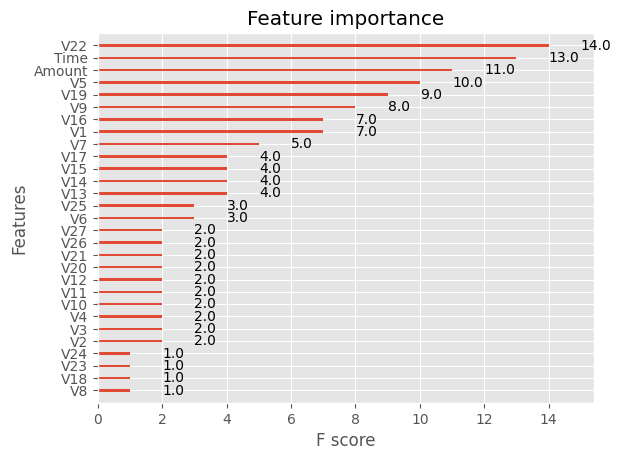

In [113]:
print('\nBest parameters found:\n')  
print(best_params)

print('\nEvaluation on the test dataset\n')  

best_f_score,best_model=do_train(best_params, param, dtrain,'train',trainY,dtest,'test',testY,print_conf_matrix=True)



print('\nVariables importance:\n')  

p = xgb.plot_importance(best_model) 
plt.show()